<a href="https://colab.research.google.com/github/amilkh/cs230-fer/blob/saliency/fer2013.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 1.x

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import *
from tensorflow.keras import backend as K
from tensorflow.keras import Model
import PIL

%matplotlib inline

In [3]:
from google.colab import drive
drive.mount('/content/drive')
data = pd.read_csv('/content/drive/My Drive/cs230 project/collab/fer2013/fer2013.csv')

#print('Number of samples in the dataset: ', data.shape[0])
# Transform images from strings to lists of integers. TODO: use an array cast
data['pixels'] = data['pixels'].apply(lambda x: [int(pixel) for pixel in x.split()])

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
emotion_cat = {0:'Angry', 1:'Disgust', 2:'Fear', 3:'Happy', 4:'Sad', 5:'Surprise', 6:'Neutral'}

# See the target distribution (check for imbalance)
#target_counts = data['emotion'].value_counts().reset_index(drop=False)
#target_counts.columns = ['emotion', 'number_samples']
#target_counts['emotion'] = target_counts['emotion'].map(emotion_cat)
#target_counts

# Select randomly 10 images
#random_seed = 1
#data_sample = data.sample(10, random_state=random_seed)
#f, axarr = plt.subplots(2, 5, figsize=(20, 10))

#i, j = 0, 0
#for idx, row in data_sample.iterrows():
#    img = np.array(row['pixels']).reshape(48,48)
#    axarr[i,j].imshow(img, cmap='gray')
#    axarr[i,j].set_title(emotion_cat[row['emotion']])
#    if j==4:
#        i += 1
#        j = 0
#    else:
#        j += 1

In [0]:
data_train = data[data['Usage']=='Training']
#print('Number samples in the training dataset: ', data_train.shape[0])

data_dev = data[data['Usage']=='PublicTest']
#print('Number samples in the development dataset: ', data_dev.shape[0])

# Retrieve train input and target
X_train, y_train = data_train['pixels'].tolist(), data_train['emotion'].values
# Reshape images to 4D (num_samples, width, height, num_channels)
X_train = np.array(X_train, dtype='float32').reshape(-1,48,48,1)
# Normalize images with max (the maximum pixel intensity is 255)
X_train = X_train/255.0

# Retrieve dev input and target
X_dev, y_dev = data_dev['pixels'].tolist(), data_dev['emotion'].values
X_dev = np.array(X_dev, dtype='float32').reshape(-1,48,48,1)
X_dev = X_dev/255.0

In [8]:
#Baseline model
model = tf.keras.models.Sequential([
    InputLayer(input_shape=(48,48,1),name="input"),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv1"),
    Dropout(0.25),
    Conv2D(filters=32,kernel_size=3,activation='relu',padding='same',name="conv2"),
    Dropout(0.25),
    MaxPool2D(pool_size=(2,2),name="maxpool1"),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv3"),
    Dropout(0.25),
    Conv2D(filters=64,kernel_size=3,activation='relu',padding='same',name="conv4"),
    Dropout(0.25),
    Flatten(),
    Dense(1024,input_shape=(24*24*64,1),activation='relu',name='fc1'),
    Dense(7,input_shape=(1024,1),activation='softmax',name='fc-softmax')
])

print("Accuracy after training")
model.compile(loss='sparse_categorical_crossentropy',optimizer='adam',metrics=['accuracy'])

Instructions for updating:
If using Keras pass *_constraint arguments to layers.
Accuracy after training


In [9]:
model.fit(X_train,y_train,batch_size=32,epochs=5,validation_data=(X_dev, y_dev))

Train on 28709 samples, validate on 3589 samples
Epoch 1/5
28709/28709 [==============================] - 17s 603us/sample - loss: 1.7027 - acc: 0.3233 - val_loss: 1.5307 - val_acc: 0.3998
Epoch 2/5
28709/28709 [==============================] - 11s 385us/sample - loss: 1.4463 - acc: 0.4406 - val_loss: 1.3911 - val_acc: 0.4533
Epoch 3/5
28709/28709 [==============================] - 11s 385us/sample - loss: 1.2769 - acc: 0.5153 - val_loss: 1.2937 - val_acc: 0.5046
Epoch 4/5
28709/28709 [==============================] - 11s 382us/sample - loss: 1.0975 - acc: 0.5876 - val_loss: 1.2299 - val_acc: 0.5386
Epoch 5/5
28709/28709 [==============================] - 11s 382us/sample - loss: 0.8575 - acc: 0.6867 - val_loss: 1.2531 - val_acc: 0.5352


# Class activation map

In [11]:
# needed for some newer functions in TF 1.0, e.g. Tensor.numpy()
!pip install --upgrade tensorflow

     |█████████████████████           | 276.1MB 1.4MB/s eta 0:01:47ERROR: Exception:
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/cli/base_command.py", line 153, in _main
    status = self.run(options, args)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/commands/install.py", line 382, in run
    resolver.resolve(requirement_set)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 201, in resolve
    self._resolve_one(requirement_set, req)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 365, in _resolve_one
    abstract_dist = self._get_abstract_dist_for(req_to_install)
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/legacy_resolve.py", line 313, in _get_abstract_dist_for
    req, self.session, self.finder, self.require_hashes
  File "/usr/local/lib/python3.6/dist-packages/pip/_internal/operations/prepare.py", line 194, in prepare_linked_

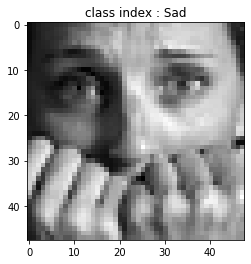

In [23]:
# Select an image to show the saliency map on
indx=56
plt.title(label = "class index : {}".format(emotion_cat[y_dev[indx]]))
plt.imshow(X_dev[indx].reshape(48,48),cmap='gray')
single_example = X_dev[indx].reshape(1,48,48,1)

In [42]:
print(model.weights[-2])
weights = model.weights[-2][:,y_dev[indx]]
get_conv_layer = Model(inputs=model.input, outputs=model.get_layer("conv4").output)
layer_feature_maps = get_conv_layer.predict(single_example)
# print(layer_feature_maps)

#vectorize
cam = 0
for k in range(layer_feature_maps.shape[-1]): 
     cam += weights[k]*layer_feature_maps[:,:,:,k]

cam = tf.reshape(cam,[24,24,1])
print(cam)
cam_resized= tf.image.resize(cam,[48,48])
#tf.Session().run(tf.variables_initializer(cam_resized))
# TODO: try to replace .numpy() with .eval()
plt.imshow(cam_resized.reshape(48,48))
plt.figure()

<tf.Variable 'fc-softmax/kernel:0' shape=(1024, 7) dtype=float32>
Tensor("Reshape_17:0", shape=(24, 24, 1), dtype=float32)


AttributeError: ignored

# Vanilla Gradients

In [0]:
input_tensors = [model.input]
example_model_output = model.output[0][y_dev[indx]]
gradients = model.optimizer.get_gradients(example_model_output, model.input)
compute_gradients = K.function(inputs = input_tensors, outputs = gradients)

gradient_fun  = Model(inputs= model.input, outputs=gradients)
gradients_value = gradient_fun(single_example.astype("float32"))

ValueError: ignored